In [1]:
import os
import copy

import torch
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from openTSNE import TSNE

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from adjustText import adjust_text

from src.utils import load_pickle_obj
from src.relative_embedding import (AnchorDescriptors,
                                    DescriptorColors,
                                    construct_relative_embeddings)

from src.graph import description_graph
from src.models import (ALBERT_embeddings,
                        BERT_embeddings,
                        BART_embeddings,
                        GPT2_embeddings,
                        RoBERTa_embeddings,
                        T5_embeddings)

In [2]:
def concat_folder(file_dict, folder):
    for ftype in file_dict:
        file_dict[ftype] = os.path.join(folder, file_dict[ftype])
        
    return file_dict

def load_embeddings(file_dict):
    embeddings = {}
    for embedding_type in file_dict:
        if os.path.isfile(file_dict[embedding_type]):
            embeddings[embedding_type] = load_pickle_obj(file_dict[embedding_type])
        else:
            embeddings[embedding_type] = None
            
    return embeddings

def construct_embeddings_for_LMs(descriptions, anchor_descriptions, model_type, finetuned_models):
    func, has_encoder, has_decoder = None, True, True
    if model_type == 'ALBERT':
        func = ALBERT_embeddings
        has_decoder = False
    elif model_type == 'BART':
        func = BART_embeddings
    elif model_type == 'BERT':
        func = BERT_embeddings
        has_decoder = False
    elif model_type == 'GPT2':
        func = GPT2_embeddings
        has_encoder = False
    elif model_type == 'RoBERTa':
        func = RoBERTa_embeddings
        has_decoder = False
    elif model_type == 'T5':
        func = T5_embeddings
        
    embedding_dict = {}
    for status in ['pretrained', 'finetuned']:
        if status == 'pretrained':
            embedding_dict[status] = func(descriptions)
        elif status == 'finetuned':
            embedding_dict[status] = func(descriptions,
                                          finetuned_model = finetuned_models[model_type])

        if has_encoder:
            embedding_dict[status] = construct_relative_embeddings(model_type,
                                                                   'encoder',
                                                                   anchor_descriptions,
                                                                   embedding_dict[status])
        if has_decoder:
            embedding_dict[status] = construct_relative_embeddings(model_type,
                                                                   'decoder',
                                                                   anchor_descriptions,
                                                                   embedding_dict[status])

    reduced_embedding_dict = {}
    for status in embedding_dict:
        iter_idx = 0
        reduced_embedding_dict[status] = {}
        for sample_idx in embedding_dict[status]:
            if embedding_dict[status][sample_idx]['description'] in anchor_descriptions:
                continue
            else:
                reduced_embedding_dict[status][iter_idx] = embedding_dict[status][sample_idx]
                iter_idx += 1

    return reduced_embedding_dict

def plot_relative_embeddings(ID_embeddings,
                             OOD_embeddings,
                             target_embedding, 
                             colored_descriptions, 
                             colors, 
                             dimension_reduction = 'tsne',
                             tsne_perplexity = 30., 
                             tsne_seed = 42,
                             switched_text = None,
                             filename = None):
    
    assert dimension_reduction in ['pca', 'tsne']
    if switched_text is not None:
        assert isinstance(switched_text, dict)
        
    if filename is not None:
        assert isinstance(filename, str)
    
    colors = copy.deepcopy(colors)
    for color in colors:
        colors[color] =  tuple([value / 255 for value in colors[color]])
    
    all_descritpions = []
    for color in colored_descriptions:
        all_descritpions += colored_descriptions[color]
        
    in_embeddings, ood_embeddings = {}, {}
    for des_name in all_descritpions:
        detect = False
        for idx in ID_embeddings:
            if des_name == ID_embeddings[idx]['description']:
                in_embeddings[des_name] = ID_embeddings[idx][target_embedding]
                detect = True
                break

        if not detect:
            for idx in OOD_embeddings:
                if des_name == OOD_embeddings[idx]['description']:
                    ood_embeddings[des_name] = OOD_embeddings[idx][target_embedding]
                    detect = True
                    break

        if not detect:
            print('Descriptor: {0} cannot find its embeddings.'.format(des_name))
                                
    assert (len(in_embeddings) + len(ood_embeddings)) == len(all_descritpions)
    
    data_matrix, in_groups = [], []
    for des_name in in_embeddings:
        data_matrix.append(in_embeddings[des_name])
        for color in colored_descriptions:
            if des_name in colored_descriptions[color]:
                detect_color = color
                break
            
        in_groups.append(detect_color)
        
    data_matrix = torch.stack(data_matrix).numpy()
    
    ood_data_matrix, ood_groups = [], []
    for des_name in ood_embeddings:
        ood_data_matrix.append(ood_embeddings[des_name])
        for color in colored_descriptions:
            if des_name in colored_descriptions[color]:
                detect_color = color

        ood_groups.append(detect_color)

    ood_data_matrix = torch.stack(ood_data_matrix).numpy()
    
    if dimension_reduction == 'pca':
        pca = PCA(n_components = 2)
        in_components = pca.fit_transform(data_matrix)
        ood_components = pca.transform(ood_data_matrix)
    elif dimension_reduction == 'tsne':    
        tsne = TSNE(n_components = 2,
                    initialization = 'pca',
                    perplexity = tsne_perplexity,
                    random_state = tsne_seed)
    
        tsne_embeddings = tsne.fit(data_matrix)
        in_components = np.array(tsne_embeddings)        
        ood_components = tsne_embeddings.transform(ood_data_matrix)
        ood_components = np.array(ood_components)
    
    in_df = pd.DataFrame(data = in_components, columns = ['Dim1', 'Dim2'])
    in_df['Group'] = in_groups
    ood_df = pd.DataFrame(data = ood_components, columns = ['Dim1', 'Dim2'])
    ood_df['Group'] = ood_groups

    fig, ax = plt.subplots(figsize = (10, 10))
    unique_in_groups = in_df['Group'].unique()  
    for group in unique_in_groups:
        indices = in_df['Group'] == group
        ax.scatter(in_df.loc[indices, 'Dim1'],
                   in_df.loc[indices, 'Dim2'],
                   c = [colors[group]],
                   edgecolor = None,
                   alpha = 0.25,
                   s = 100)

    unique_ood_groups = ood_df['Group'].unique()
    for group in unique_ood_groups:
        indices = ood_df['Group'] == group
        ax.scatter(ood_df.loc[indices, 'Dim1'],
                   ood_df.loc[indices, 'Dim2'],
                   c = [colors[group]],
                   edgecolor = 'black',
                   alpha = 1.,
                   s = 100)

    iter_idx = 0
    times = FontProperties(family = "Times New Roman", size = 32)
    annotations = []
    for descriptor in ood_embeddings:
        if switched_text is not None:
            if descriptor in switched_text:
                descriptor = switched_text[descriptor]
            
        annotations.append(ax.annotate(descriptor, (ood_components[iter_idx, 0], ood_components[iter_idx, 1]),
                    fontproperties = times, fontweight = 'bold', ha = 'left', va = 'bottom'))

        iter_idx += 1

    adjust_text(annotations, ax = ax)
    
    if dimension_reduction == 'pca':
        plt.xlabel('PCA Dim 1')
        plt.ylabel('PCA Dim 2')
        plt.title('PCA of LLM embeddings')
    elif dimension_reduction == 'tsne':
        plt.xlabel('t-SNE Dim 1')
        plt.ylabel('t-SNE Dim 2')
        plt.title('t-SNE of LLM embeddings')

    if filename is not None:
        if not filename.endswith('.png'):
            filename += '.png'

        plt.savefig(filename, 
                    dpi = 300, 
                    bbox_inches = 'tight')
        print('Save as file: {0} successfully.'.format(filename))
    else:
        plt.show()
    
    return None

In [3]:
folder_name = './outputs'
bert_files = {'pretrained': 'pretrained-BERT_embeddings.pkl',
              'finetuned': 'finetuned-BERT-N20kE3_embeddings.pkl'}
roberta_files = {'pretrained': 'pretrained-RoBERTa_embeddings.pkl',
                 'finetuned': 'finetuned-RoBERTa-N100kE1_embeddings.pkl'}

model_folder = 'finetuned_models'
finetuned_models = {'BERT': 'finetuned-bert-base-uncased-N20kE3',
                    'RoBERTa': 'finetuned-roberta-base-N100kE1'}

finetuned_models = concat_folder(finetuned_models, model_folder)

bert_files = concat_folder(bert_files, folder_name)
roberta_files = concat_folder(roberta_files, folder_name)

ID_bert_embeddings = load_embeddings(bert_files)
ID_roberta_embeddings = load_embeddings(roberta_files)

In [4]:
# The warning is caused by the lack of saving parameter of the linear predictor
# Becuase embeddings are extracted at the output of the main computational module,
# it do not affect the result of Sensory-CoKGE.
anchor_descriptions = copy.deepcopy(AnchorDescriptors)
OOD_descriptions = {'OOD_fruity': ['waxberry', 'banana', 'dragon fruit', 'mango'],
                    'OOD_sour/fermented': ['tartaric acidity', 'phosphoric acidity', 'beer', 'Bourbon wine']}

switched_text = {'waxberry': 'F1',
                 'banana': 'F2',
                 'dragon fruit': 'F3',
                 'mango': 'F4',
                 'tartaric acidity': 'S1',
                 'phosphoric acidity': 'S2',
                 'beer': 'S3',
                 'Bourbon wine': 'S4'}

descriptions = copy.deepcopy(anchor_descriptions)
for OOD_group in OOD_descriptions:
    descriptions += OOD_descriptions[OOD_group]

OOD_bert_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'BERT', finetuned_models)
OOD_roberta_embeddings = construct_embeddings_for_LMs(descriptions, anchor_descriptions, 'RoBERTa', finetuned_models)

colored_descriptions = {}
description_colors = copy.deepcopy(DescriptorColors)

graph = description_graph()
for descritpion in graph.descriptions:
    for color in description_colors:
        if graph.distance_between_descriptions(descritpion, color) < 10.:
            if color not in colored_descriptions.keys():
                colored_descriptions[color] = [descritpion]
            else:
                colored_descriptions[color].append(descritpion)  
                
for color in colored_descriptions:
    colored_descriptions[color] = list(set(colored_descriptions[color]))

for OOD_group in OOD_descriptions:
    for color_group in description_colors:
        if color_group in OOD_group:
            colored_descriptions[OOD_group] = OOD_descriptions[OOD_group]
            description_colors[OOD_group] = description_colors[color_group]
            break

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of RobertaModel were not initialized from the model checkpoint at finetuned_models/finetuned-roberta-base-N100kE1 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Save as file: OOD_Pretrained_BERT.png successfully.


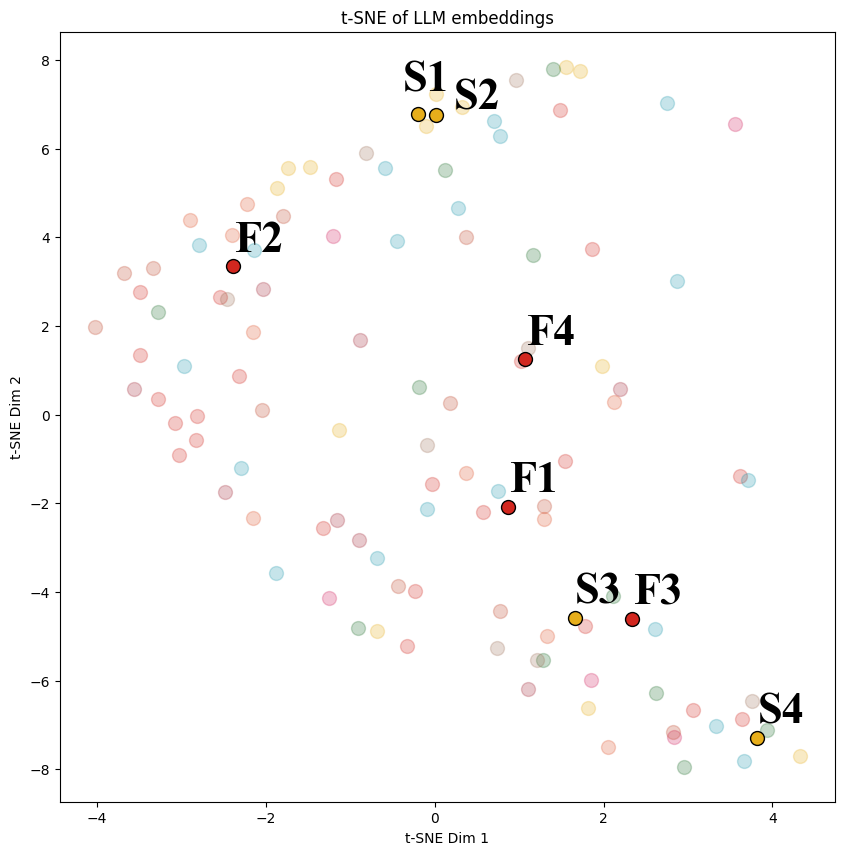

In [5]:
# use in journal
# pretained BERT
plot_relative_embeddings(ID_bert_embeddings['pretrained'],
                         OOD_bert_embeddings['pretrained'],
                         'relative_encoder_embedding',
                         colored_descriptions,
                         description_colors,
                         switched_text = switched_text,
                         filename = 'OOD_Pretrained_BERT')

Save as file: OOD_Finetuned_BERT.png successfully.


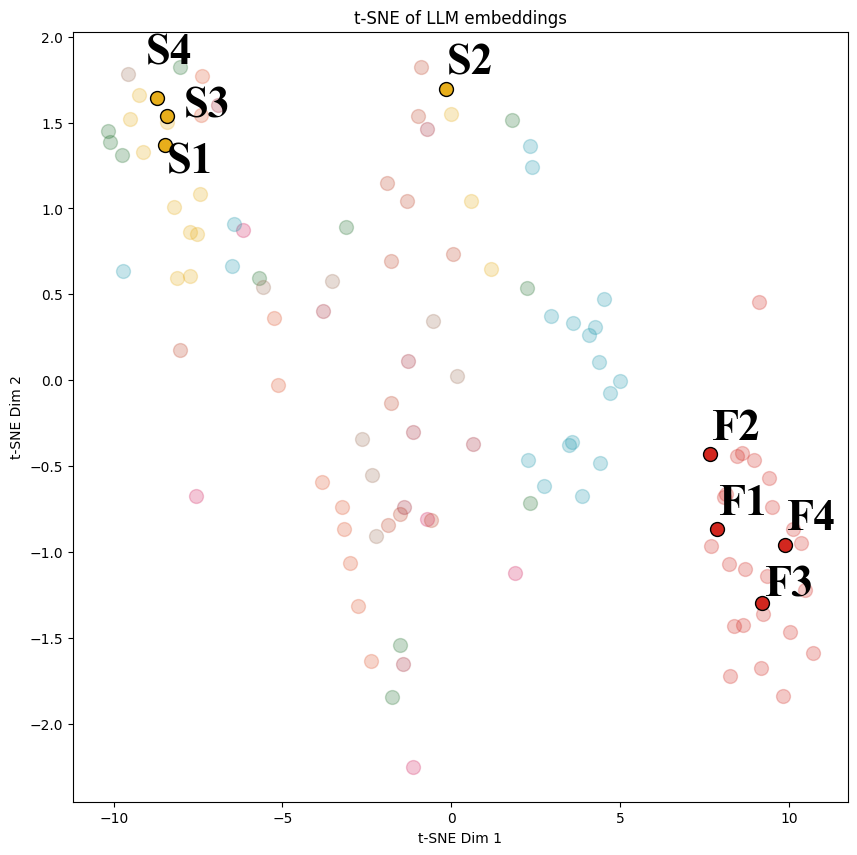

In [6]:
# use in journal
# finetuned BERT
plot_relative_embeddings(ID_bert_embeddings['finetuned'],
                         OOD_bert_embeddings['finetuned'],
                         'relative_encoder_embedding',
                         colored_descriptions,
                         description_colors,
                         switched_text = switched_text,
                         filename = 'OOD_Finetuned_BERT')

Save as file: OOD_Pretrained_RoBERTa.png successfully.


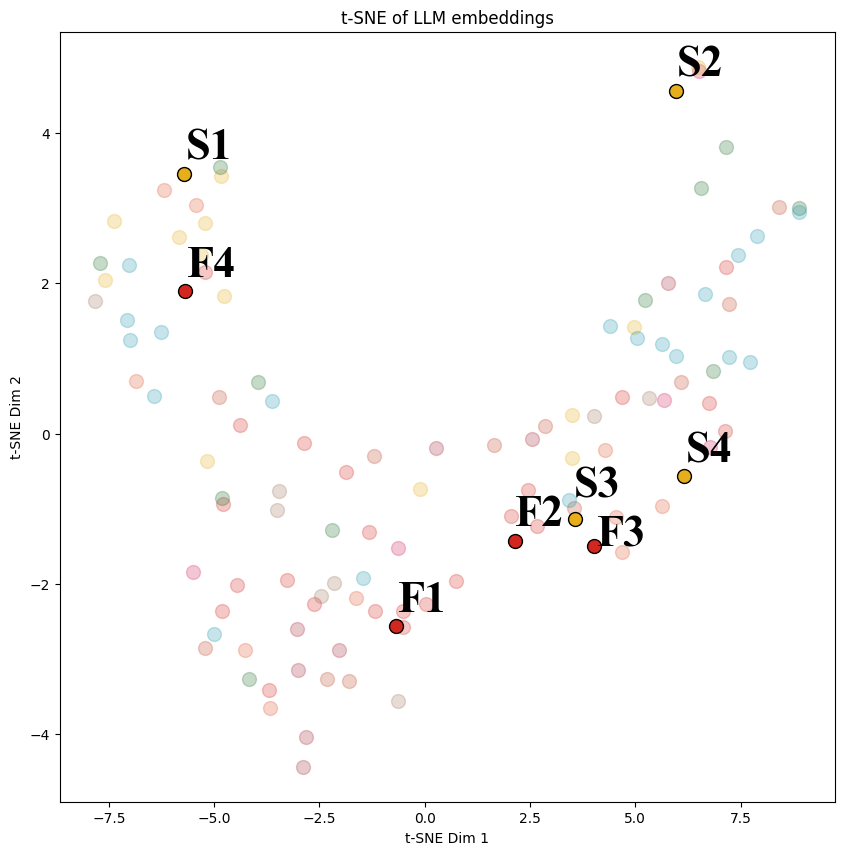

In [7]:
# use in journal
# pretained RoBERTa
plot_relative_embeddings(ID_roberta_embeddings['pretrained'],
                         OOD_roberta_embeddings['pretrained'],
                         'relative_encoder_embedding',
                         colored_descriptions,
                         description_colors,
                         switched_text = switched_text,
                         filename = 'OOD_Pretrained_RoBERTa')

Save as file: OOD_Finetuned_RoBERTa.png successfully.


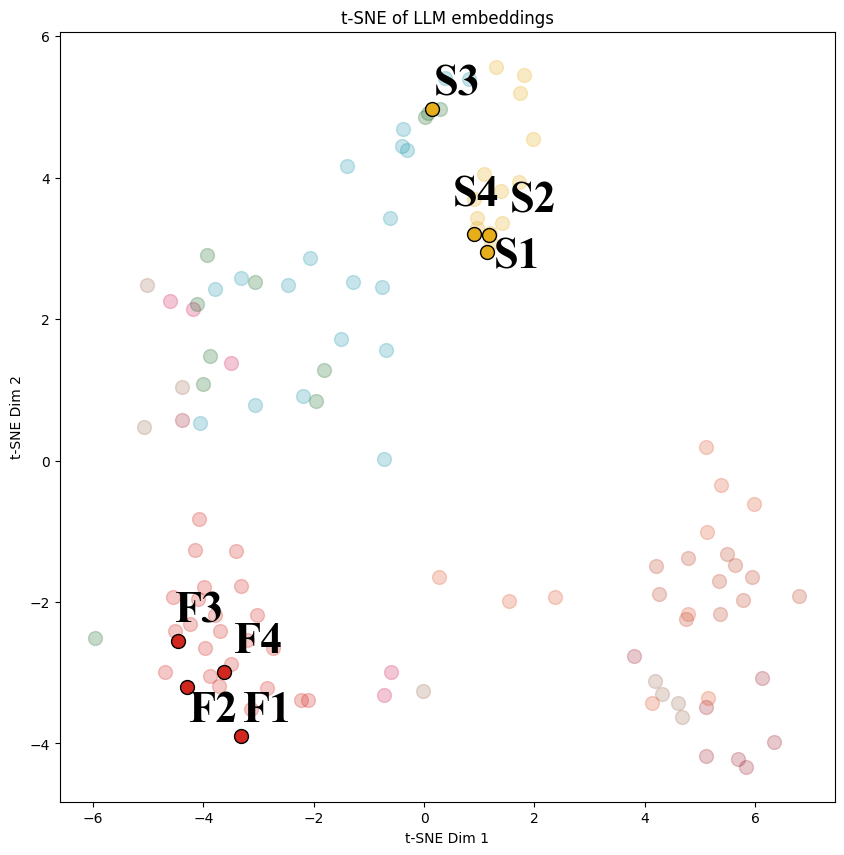

In [8]:
# use in journal
# finetuned RoBERTa
plot_relative_embeddings(ID_roberta_embeddings['finetuned'],
                         OOD_roberta_embeddings['finetuned'],
                         'relative_encoder_embedding',
                         colored_descriptions,
                         description_colors,
                         switched_text = switched_text,
                         filename = 'OOD_Finetuned_RoBERTa')